# Necessary libraries

In [28]:
# First we'll import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.special import softmax
from scipy.stats import dirichlet
import pytensor.tensor as pt
import pymc as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

# Loading data

In [ ]:
# Now we'll load the dataset
dataset = pd.read_csv('spotify.csv')

# Print the shape of the dataset
print("Dataset shape:", dataset.shape)

# Print the head of the dataset
dataset.head()

Dataset shape: (114000, 21)


Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falling In Love          71       201933     False   
4                     Hold On          82       198853     False   

   danceability  energy  ...  loudness  mode  speechiness  acousticness  \
0         0.676  0.4610  ...    -6.746     0       0.1430        0.0322   
1         0.420  0.1660  ...   -17.235     1       0.0763        0.9240   
2         0.438  0.3590  ...    -9.734     1       0.0557        0.2100   
3         0.266  0.0596  ...   -18.515     1       0.0363        0.9050   
4         0.618  0.4430  ...    -9.681     1       0.0526        0.4690   

   instrumentalness  liveness  valence    tempo  time_signature  track_genre  
0          0.000001    0.3580    0.715   87.917               4     acoustic  
1          0.000006    0.1010    0.267   77.489               4     acoustic  
2          0.000000    0.1170    0.120   76.332               4     acoustic  
3          0.000071    0.1320    0.143  181.740               3     acoustic  
4          0.000000    0.0829    0.167  119.949               4     acoustic  

[5 rows x 21 columns]

# Data preprocessing

In [ ]:
# First we'll remove duplicate rows
dataset.drop_duplicates(inplace=True)
# Now we'll check for missing values
missing_counts = dataset.isnull().sum()
print("Missing entries per column:")
print(missing_counts)
# Remove rows with missing values
dataset.dropna(inplace=True)
# There are certain rows which have same artists, track_name, duration_ms and other features except for album_name, track_id and popularity.
# We consider them as duplicates and remove them.
duplicates = dataset.duplicated(subset=['artists', 'track_name', 'duration_ms', 'key', 'mode', 'time_signature', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence'], keep='first')
dataset = dataset[~duplicates]
# Now we'll check the shape of the dataset again
print("Dataset shape after removing duplicates:", dataset.shape)
# Head of new dataset
dataset.head()


Missing entries per column:
Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64
Dataset shape after removing duplicates: (83901, 21)


Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falling In Love          71       201933     False   
4                     Hold On          82       198853     False   

   danceability  energy  ...  loudness  mode  speechiness  acousticness  \
0         0.676  0.4610  ...    -6.746     0       0.1430        0.0322   
1         0.420  0.1660  ...   -17.235     1       0.0763        0.9240   
2         0.438  0.3590  ...    -9.734     1       0.0557        0.2100   
3         0.266  0.0596  ...   -18.515     1       0.0363        0.9050   
4         0.618  0.4430  ...    -9.681     1       0.0526        0.4690   

   instrumentalness  liveness  valence    tempo  time_signature  track_genre  
0          0.000001    0.3580    0.715   87.917               4     acoustic  
1          0.000006    0.1010    0.267   77.489               4     acoustic  
2          0.000000    0.1170    0.120   76.332               4     acoustic  
3          0.000071    0.1320    0.143  181.740               3     acoustic  
4          0.000000    0.0829    0.167  119.949               4     acoustic  

[5 rows x 21 columns]

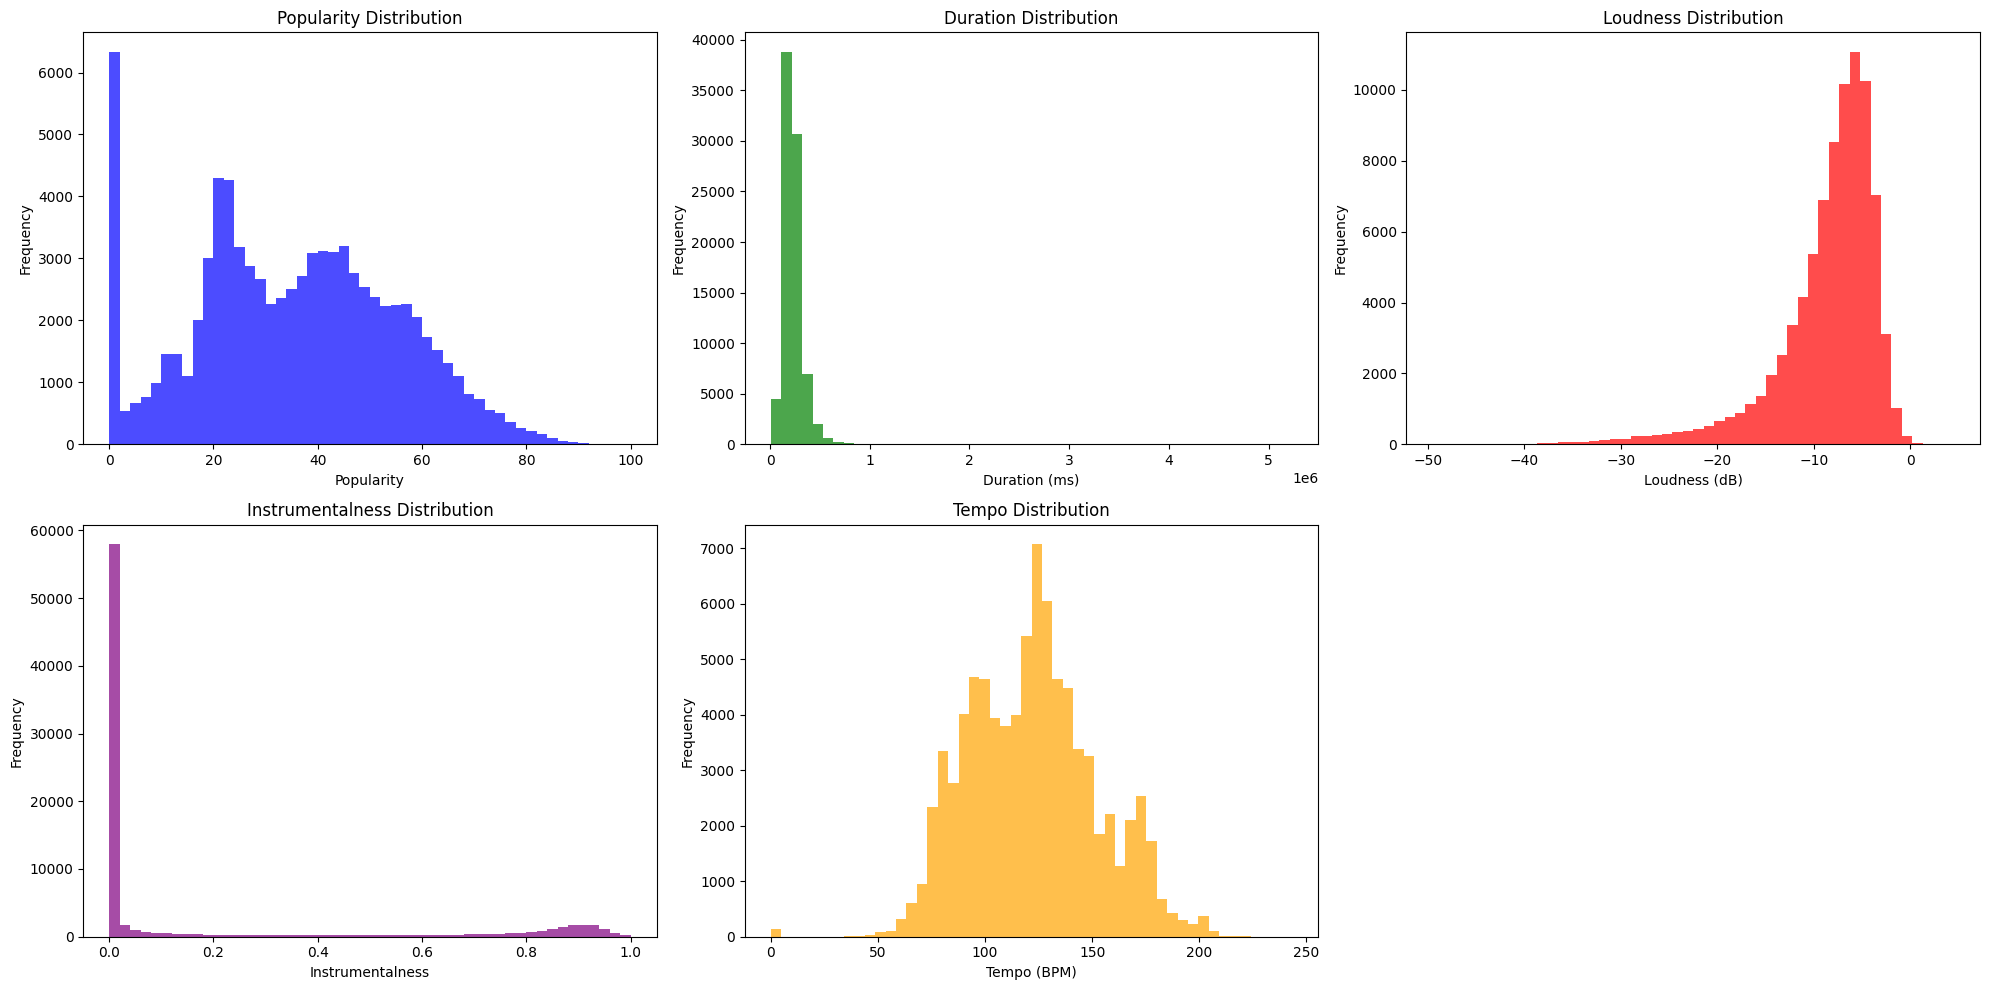

In [ ]:
# Here we view the distribution of features 'popularity', 'duration_ms', 'loudness', 'instrumentalness', and 'tempo'
# This is to check if there are any outliers in the dataset and to see what tranformations we need to apply for scaling
# We will use the matplotlib to visualize the distribution of these features
plt.figure(figsize=(20, 10))
plt.subplot(2, 3, 1)
plt.hist(dataset['popularity'], bins=50, color='blue', alpha=0.7)
plt.title('Popularity Distribution')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.subplot(2, 3, 2)
plt.hist(dataset['duration_ms'], bins=50, color='green', alpha=0.7)
plt.title('Duration Distribution')
plt.xlabel('Duration (ms)')
plt.ylabel('Frequency')
plt.subplot(2, 3, 3)
plt.hist(dataset['loudness'], bins=50, color='red', alpha=0.7)
plt.title('Loudness Distribution')
plt.xlabel('Loudness (dB)')
plt.ylabel('Frequency')
plt.subplot(2, 3, 4)
plt.hist(dataset['instrumentalness'], bins=50, color='purple', alpha=0.7)
plt.title('Instrumentalness Distribution')
plt.xlabel('Instrumentalness')
plt.ylabel('Frequency')
plt.subplot(2, 3, 5)
plt.hist(dataset['tempo'], bins=50, color='orange', alpha=0.7)
plt.title('Tempo Distribution')
plt.xlabel('Tempo (BPM)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
# SCALING
# From above plots, we observe:
# 1. Popularity has a roughly unimodal distribution with a bit right skewness. So we can use MinMaxScaler to preserve the shape of distribution.
# 2. duration_ms has right skewness and large range. So we use log transform followed by MinMax.
# 3. loudness has unimodal distribution and is left skewed. So we use MinMaxScaler.
# 4. instrumentalness is heavily concentrated at 0 and is right skewed. So we'll use power transformation to spread out density at 0.
# 5. tempo is roughly bell shaped. So we use StandardScaler.

pop_scaler = MinMaxScaler()
df=dataset.copy()
df['popularity'] = pop_scaler.fit_transform(df[['popularity']])
df['duration_ms_log'] = np.log(df['duration_ms'])
dur_scaler = MinMaxScaler()
df['duration_ms'] = dur_scaler.fit_transform(df[['duration_ms_log']])
df.drop(columns=['duration_ms_log'], inplace=True)
loud_scaler = MinMaxScaler()
df['loudness'] = loud_scaler.fit_transform(df[['loudness']])
pt = PowerTransformer(method='yeo-johnson')
df['instrumentalness'] = pt.fit_transform(df[['instrumentalness']])
tempo_scaler = StandardScaler()
df['tempo'] = tempo_scaler.fit_transform(df[['tempo']])
print("Shape of scaled dataset:", df.shape)
df.head()

Shape of scaled dataset: (83901, 21)


Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy        0.73     0.513117     False   
1            Ghost - Acoustic        0.55     0.445612     False   
2              To Begin Again        0.57     0.499094     False   
3  Can't Help Falling In Love        0.71     0.492374     False   
4                     Hold On        0.82     0.489977     False   

   danceability  energy  ...  loudness  mode  speechiness  acousticness  \
0         0.676  0.4610  ...  0.791392     0       0.1430        0.0322   
1         0.420  0.1660  ...  0.597377     1       0.0763        0.9240   
2         0.438  0.3590  ...  0.736123     1       0.0557        0.2100   
3         0.266  0.0596  ...  0.573701     1       0.0363        0.9050   
4         0.618  0.4430  ...  0.737103     1       0.0526        0.4690   

   instrumentalness  liveness  valence     tempo  time_signature  track_genre  
0         -0.635199    0.3580    0.715 -1.138750               4     acoustic  
1         -0.635126    0.1010    0.267 -1.485560               4     acoustic  
2         -0.635215    0.1170    0.120 -1.524039               4     acoustic  
3         -0.634083    0.1320    0.143  1.981575               3     acoustic  
4         -0.635215    0.0829    0.167 -0.073444               4     acoustic  

[5 rows x 21 columns]

In [ ]:
# Convert categorical feature values into numeric values
categorical_columns = ["track_id", "album_name", "track_name", "track_genre"]
dataset_scaled = df
for col in categorical_columns:
    #  astype('category') converts the column into pandas' categorical type
    # function .cat.codes extracts numerical codes for each unique category
    dataset_scaled[col] = dataset_scaled[col].astype('category').cat.codes

dataset_scaled.head()

Unnamed: 0  track_id                 artists  album_name  track_name  \
0           0     58783             Gen Hoshino        8014       11741   
1           1     52101            Ben Woodward       14630       22528   
2           2     18491  Ingrid Michaelson;ZAYN       38672       60774   
3           3     72912            Kina Grannis        8487        9580   
4           4     63836        Chord Overstreet       16700       25689   

   popularity  duration_ms  explicit  danceability  energy  ...  loudness  \
0        0.73     0.513117     False         0.676  0.4610  ...  0.791392   
1        0.55     0.445612     False         0.420  0.1660  ...  0.597377   
2        0.57     0.499094     False         0.438  0.3590  ...  0.736123   
3        0.71     0.492374     False         0.266  0.0596  ...  0.573701   
4        0.82     0.489977     False         0.618  0.4430  ...  0.737103   

   mode  speechiness  acousticness  instrumentalness  liveness  valence  \
0     0       0.1430        0.0322         -0.635199    0.3580    0.715   
1     1       0.0763        0.9240         -0.635126    0.1010    0.267   
2     1       0.0557        0.2100         -0.635215    0.1170    0.120   
3     1       0.0363        0.9050         -0.634083    0.1320    0.143   
4     1       0.0526        0.4690         -0.635215    0.0829    0.167   

      tempo  time_signature  track_genre  
0 -1.138750               4            0  
1 -1.485560               4            0  
2 -1.524039               4            0  
3  1.981575               3            0  
4 -0.073444               4            0  

[5 rows x 21 columns]

In [ ]:
# Feature engineering:
# We'll define 'tempo_category' based on the tempo values
def categorize_tempo(value):
    if value < 0.33:
        return 'slow'
    elif value < 0.66:
        return 'medium'
    else:
        return 'fast'

dataset_scaled['tempo_category'] = dataset_scaled['tempo'].apply(categorize_tempo)
# Next we'll create new feature called 'mood_bucket' using valence and danceability
def mood_bucket(valence, danceability):
    if valence >= 0.66:
        if danceability >= 0.66:
            return 'Party Vibes'
        elif danceability >= 0.33:
            return 'Feel-Good Flow'
        else:
            return 'Peaceful & Warm'
    elif valence >= 0.33:
        if danceability >= 0.66:
            return 'Mid-energy'
        elif danceability >= 0.33:
            return 'Balanced Energy'
        else:
            return 'Calm and contemplative'
    else:
        if danceability >= 0.66:
            return 'Dark Dance'
        elif danceability >= 0.33:
            return 'Moody Beats'
        else:
            return 'Sad and low energy'

dataset_scaled['mood_bucket'] = dataset_scaled.apply(
    lambda row: mood_bucket(row['valence'], row['danceability']), axis=1
)
print(dataset_scaled[['valence', 'danceability', 'mood_bucket']].head())
# Convert the new features into numeric values
tempo_encoder = LabelEncoder()
dataset_scaled['tempo_category_encoded'] = tempo_encoder.fit_transform(dataset_scaled['tempo_category'])
mood_encoder = LabelEncoder()
dataset_scaled['mood_bucket_encoded'] = mood_encoder.fit_transform(dataset_scaled['mood_bucket'])
# Next we create a feature called 'collaboration' which is a flag for existence of more than 1 artist for a song
# if more than one artist is present then collaboration=1 otherwise 0
def is_collaboration(artists):
    return int(";" in artists)
dataset_scaled['collaboration'] = dataset_scaled['artists'].apply(is_collaboration)
# size of dataset after adding new features:
print("Shape of dataset after adding new features:", dataset_scaled.shape)
dataset_scaled.head()

   valence  danceability         mood_bucket
0    0.715         0.676         Party Vibes
1    0.267         0.420         Moody Beats
2    0.120         0.438         Moody Beats
3    0.143         0.266  Sad and low energy
4    0.167         0.618         Moody Beats
Shape of dataset after adding new features: (83901, 26)


Unnamed: 0  track_id                 artists  album_name  track_name  \
0           0     58783             Gen Hoshino        8014       11741   
1           1     52101            Ben Woodward       14630       22528   
2           2     18491  Ingrid Michaelson;ZAYN       38672       60774   
3           3     72912            Kina Grannis        8487        9580   
4           4     63836        Chord Overstreet       16700       25689   

   popularity  duration_ms  explicit  danceability  energy  ...  liveness  \
0        0.73     0.513117     False         0.676  0.4610  ...    0.3580   
1        0.55     0.445612     False         0.420  0.1660  ...    0.1010   
2        0.57     0.499094     False         0.438  0.3590  ...    0.1170   
3        0.71     0.492374     False         0.266  0.0596  ...    0.1320   
4        0.82     0.489977     False         0.618  0.4430  ...    0.0829   

   valence     tempo  time_signature  track_genre  tempo_category  \
0    0.715 -1.138750               4            0            slow   
1    0.267 -1.485560               4            0            slow   
2    0.120 -1.524039               4            0            slow   
3    0.143  1.981575               3            0            fast   
4    0.167 -0.073444               4            0            slow   

          mood_bucket  tempo_category_encoded  mood_bucket_encoded  \
0         Party Vibes                       2                    6   
1         Moody Beats                       2                    5   
2         Moody Beats                       2                    5   
3  Sad and low energy                       0                    8   
4         Moody Beats                       2                    5   

   collaboration  
0              0  
1              0  
2              1  
3              0  
4              0  

[5 rows x 26 columns]

# EDA on dataset

First we try to find correlation between various features using Bayesian approach and visualise using heatmap. We use MCMC sampling to approximate the posterior distribution for the correlation coefficient 'rho' and take mean of the distribution as the final value for the heatmap.

<ipython-input-8-221aa80c25c1>:15: RuntimeWarning: divide by zero encountered in arctanh
  z = np.arctanh(r)
<ipython-input-8-221aa80c25c1>:15: RuntimeWarning: divide by zero encountered in arctanh
  z = np.arctanh(r)
<ipython-input-8-221aa80c25c1>:15: RuntimeWarning: divide by zero encountered in arctanh
  z = np.arctanh(r)
<ipython-input-8-221aa80c25c1>:15: RuntimeWarning: divide by zero encountered in arctanh
  z = np.arctanh(r)
<ipython-input-8-221aa80c25c1>:15: RuntimeWarning: divide by zero encountered in arctanh
  z = np.arctanh(r)
<ipython-input-8-221aa80c25c1>:15: RuntimeWarning: divide by zero encountered in arctanh
  z = np.arctanh(r)
<ipython-input-8-221aa80c25c1>:15: RuntimeWarning: divide by zero encountered in arctanh
  z = np.arctanh(r)


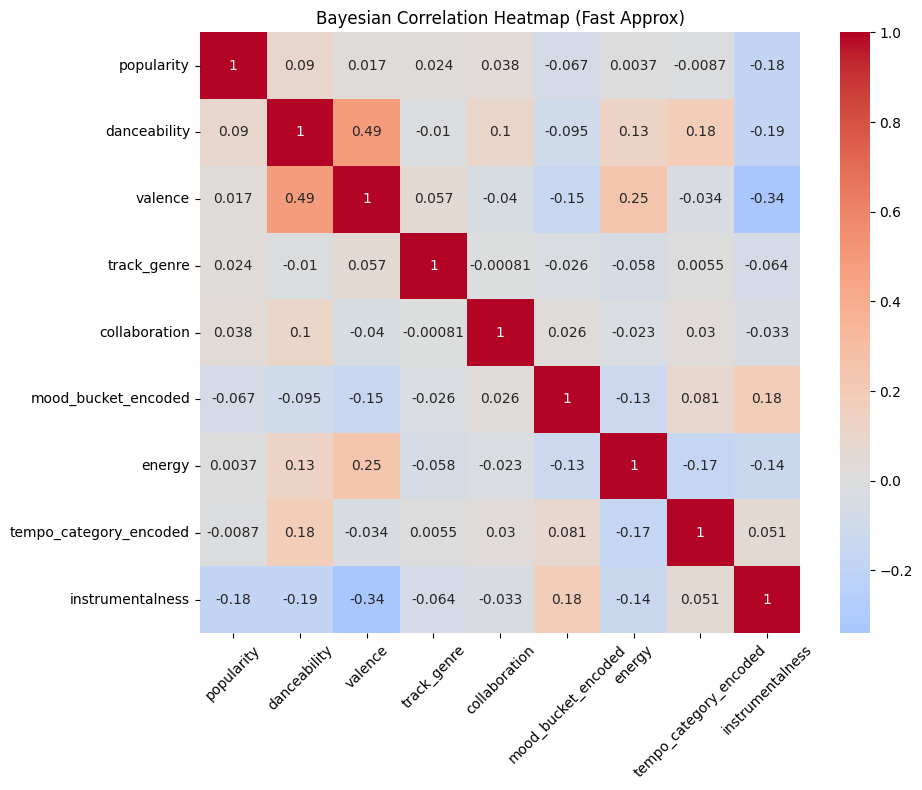

In [ ]:
# We find correlation using Fisher z-transform
def bayesian_corr_matrix(data, column_names, draws=10000, seed=42):
    rng = np.random.default_rng(seed)  # generate random number
    num_columns = len(column_names)
    corr_matrix = np.zeros((num_columns, num_columns))
    for i in range(num_columns):
        for j in range(i, num_columns):
            col1 = data[column_names[i]]
            col2 = data[column_names[j]]
            combined = pd.concat([col1, col2], axis=1).dropna().values
            if len(combined) <= 3:
                corr = 0.0
            else:
                r = np.corrcoef(combined[:, 0], combined[:, 1])[0, 1]
                z = np.arctanh(r)
                se = 1 / np.sqrt(len(combined) - 3)
                z_samples = rng.normal(z, se, size=draws)
                rho_samples = np.tanh(z_samples)
                corr = np.mean(rho_samples)
            corr_matrix[i, j] = corr
            corr_matrix[j, i] = corr

    return pd.DataFrame(corr_matrix, index=column_names, columns=column_names)

corr_cols = ["popularity", "danceability", "valence", "track_genre","collaboration", "mood_bucket_encoded", "energy","tempo_category_encoded", "instrumentalness"]
corr_df = bayesian_corr_matrix(dataset_scaled, corr_cols)
# Visualise the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", center=0, square=True)
plt.title("Bayesian Correlation Heatmap (Fast Approx)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Inferences:
1. Tracks which are more danceable are usually more positive.
2. Happier songs tend to have more energy.
3. Instrumental tracks are generally less popular, less danceable, and less happy.
4. Popularity cannot be strongly explained by any single variable as its correlation with every feature is low.
5. Faster tracks may be more danceable but not much energetic.
6. Collaboration is not much related to popularity.

Next we'll try to find answer for: Which genres do most popular artists work on?
We use bayesian categorical estimation, i.e., Dirichlet-Multinomial mode to find it.

Estimated Genre Proportions Among Popular Songs:
track_genre
20    0.431586
67    0.284833
51    0.283581
dtype: float64


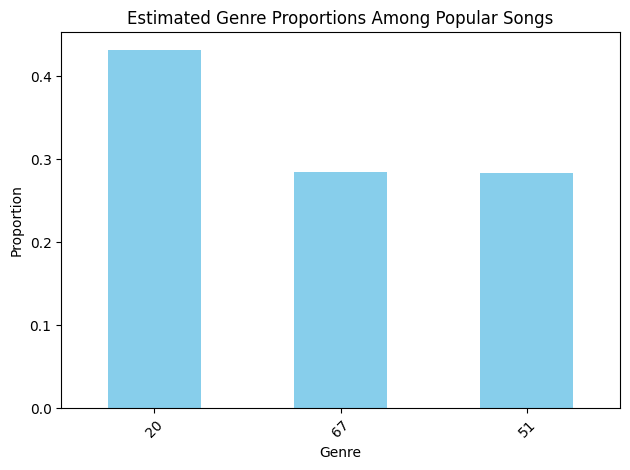

In [ ]:
# Create a dataframe to store popular songs with 'popularity'>0.97
data_pop = dataset_scaled[dataset_scaled['popularity'] > 0.97]
genre_counts = data_pop['track_genre'].value_counts()
# We take uniform Dirichlet prior (alpha = 1) for each genre
alpha_prior = np.ones(len(genre_counts))
posterior_alpha = alpha_prior + genre_counts.values
# Dirichlet posterior's samples
n_samples = 10000
samples = dirichlet.rvs(posterior_alpha, size=n_samples)
# Compute the posterior mean for each genre
mean_pos = np.mean(samples, axis=0)
est_genre = pd.Series(mean_pos, index=genre_counts.index)
print("Estimated Genre Proportions Among Popular Songs:")
print(est_genre.sort_values(ascending=False))
est_genre.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Estimated Genre Proportions Among Popular Songs")
plt.xlabel("Genre")
plt.ylabel("Proportion")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Create the mapping from code to genre name
genre_mapping = dict(enumerate(dataset['track_genre'].astype('category').cat.categories))

# Get genres for specific codes
print("Code 20:", genre_mapping[20])
print("Code 67:", genre_mapping[67])
print("Code 51:", genre_mapping[51])

Code 20: dance
Code 67: latin
Code 51: hip-hop


Next we'll find the answer to: Which mood_bucket do most famous songs lie on?

Bayesian Mood Bucket Proportions (Posterior Mean):
mood_bucket
Dark Dance         0.251914
Party Vibes        0.251424
Balanced Energy    0.249358
Moody Beats        0.247304
dtype: float64


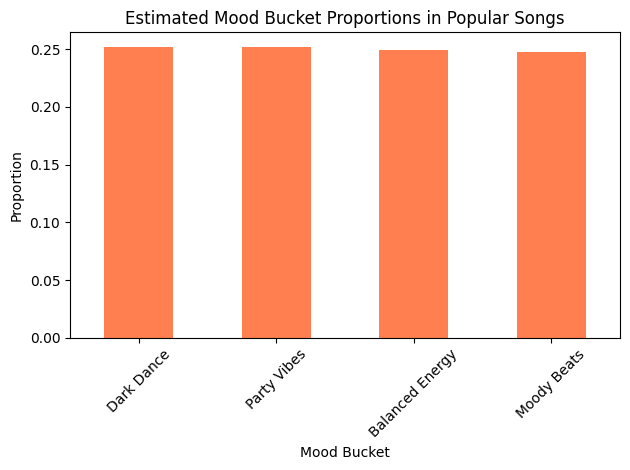

In [ ]:
mood_counts = data_pop['mood_bucket'].value_counts()
# We take uniform Dirichlet prior (alpha=1) for each mood bucket
alpha_prior = np.ones(len(mood_counts))
alpha_pos = alpha_prior + mood_counts.values
# Dirichlet posterior's samples
n_samples = 10000
samples = dirichlet.rvs(alpha_pos, size=n_samples)
mean_pos_mood = np.mean(samples, axis=0)
est_mood = pd.Series(mean_pos_mood, index=mood_counts.index)
print("Bayesian Mood Bucket Proportions (Posterior Mean):")
print(est_mood.sort_values(ascending=False))
est_mood.sort_values(ascending=False).plot(kind='bar', color='coral')
plt.title("Estimated Mood Bucket Proportions in Popular Songs")
plt.xlabel("Mood Bucket")
plt.ylabel("Proportion")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

What tempo are used in most popular songs and by most popular artists?

Bayesian Tempo Category Proportions:
tempo_category
slow    1.0
dtype: float64


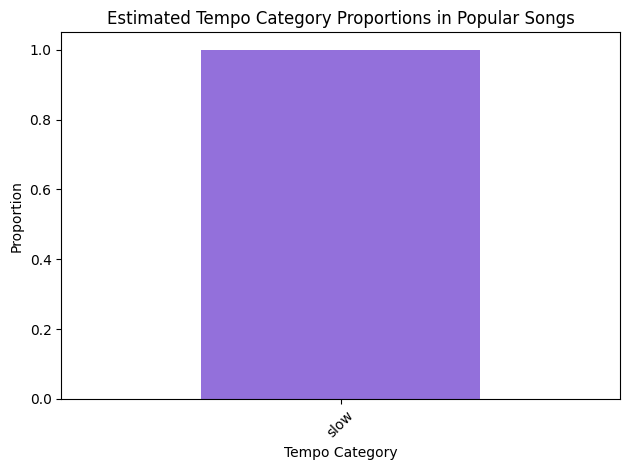

In [ ]:
tempo_counts = data_pop['tempo_category'].value_counts()
# We take uniform Dirichlet prior with alpha = 1 for each category of tempo
alpha_prior = np.ones(len(tempo_counts))
posterior_alpha = alpha_prior + tempo_counts.values
# Dirichlet posterior's sample
n_samples = 10000
samples = dirichlet.rvs(posterior_alpha, size=n_samples)
mean_pos_tempo = np.mean(samples, axis=0)
est_tempo = pd.Series(mean_pos_tempo, index=tempo_counts.index)
print("Bayesian Tempo Category Proportions:")
print(est_tempo.sort_values(ascending=False))
est_tempo.sort_values(ascending=False).plot(kind='bar', color='mediumpurple')
plt.title("Estimated Tempo Category Proportions in Popular Songs")
plt.xlabel("Tempo Category")
plt.ylabel("Proportion")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

At what energy level do popular artists usually work?

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_energy  0.727  0.203    0.39    1.115       0.01    0.016     638.0   

           ess_tail  r_hat  
mu_energy     534.0    1.0  


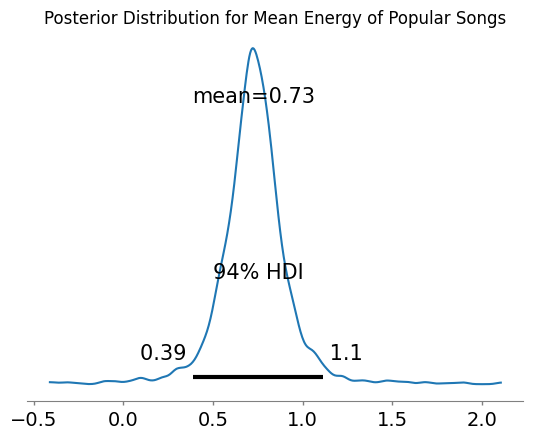

In [ ]:
with pm.Model() as energy_model:
    mu_energy = pm.Normal("mu_energy", mu=data_pop['energy'].mean(), sigma=1)
    sigma_energy = pm.HalfNormal("sigma_energy", sigma=1)
    energy_obs = pm.Normal("energy_obs", mu=mu_energy, sigma=sigma_energy, observed=data_pop['energy'].values)
    trace_energy = pm.sample(draws=1000, tune=500, target_accept=0.9, cores=2, progressbar=False, return_inferencedata=True)

print(az.summary(trace_energy, var_names=["mu_energy"]))
az.plot_posterior(trace_energy, var_names=["mu_energy"])
plt.title("Posterior Distribution for Mean Energy of Popular Songs")
plt.show()

Inference: We assume the energy level of popular songs as normal distribution with mean prior as normal and standard deviation prior as half normal. Then we use MCMC sampling to get posterior distribution of the mean energy level. \\
Mean energy level: 0.71

# Regression on 'popularity' feature

In [ ]:
# Only 30000 data will be taken entirely
# Out of that, we take 70% as train, 30% as test data set
# Data is taken in a stratified manner with respect to popularity
data_pop_reg = dataset_scaled.sample(n=30000, random_state=42)
data_pop_reg['popularity_bin'] = pd.qcut(data_pop_reg['popularity'], q=10, duplicates='drop')
train_data, test_data = train_test_split(data_pop_reg, test_size=0.3, stratify=data_pop_reg['popularity_bin'], random_state=42)
train_data = train_data.drop(columns='popularity_bin')
test_data = test_data.drop(columns='popularity_bin')
print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")

Train size: 21000
Test size: 9000


In [ ]:
features = ['duration_ms', 'danceability', 'energy', 'loudness', 'mode', 'acousticness', 'liveness', 'valence', 'tempo', 'track_genre', 'speechiness', 'mood_bucket_encoded']
X_train = train_data[features].values
y_train = train_data['popularity'].values
p = X_train.shape[1]
h1 = 64 # dimension of hidden layer-1
h2 = 32 # dimension of hidden layer-2
with pm.Model() as bnn_model:
    X = pm.Data("X", X_train)
    y = pm.Data("y", y_train)
    # Hidden layer-1 starts
    w1 = pm.Normal("w1", mu=0, sigma=0.5, shape=(p, h1))
    b1 = pm.Normal("b1", mu=0, sigma=0.5, shape=(h1,))
    act1 = pt.tanh(pt.dot(X, w1) + b1) # applying activation function on hidden layer-1
    # Hidden layer-2 starts
    w2 = pm.Normal("w2", mu=0, sigma=0.5, shape=(h1, h2))
    b2 = pm.Normal("b2", mu=0, sigma=0.5, shape=(h2,))
    act2 = pt.tanh(pt.dot(act1, w2) + b2) # applying activation function on hidden layer-2
    # Output layer starts
    w3 = pm.Normal("w3", mu=0, sigma=0.5, shape=(h2,))
    b3 = pm.Normal("b3", mu=0, sigma=0.5)
    output = pt.dot(act2, w3) + b3 # This is output layer
    sigma = pm.HalfNormal("sigma", sigma=5)
    y_obs = pm.Normal("y_obs", mu=output, sigma=sigma, observed=y)

# Now we fit the model using ADVI
with bnn_model:
    approx = pm.fit(n=5000, method='advi', progressbar=True)
    trace = approx.sample(1000)

Output()

In [ ]:
# Test data
test_data_X = test_data[features].values
test_data_y = test_data['popularity'].values
with bnn_model:
    pm.set_data({'X': test_data_X})
    # Take deterministic outputs from model's forward pass
    output_fn = pm.draw(output, draws=1000)

# Now evaluation part:
mean_pred_y = np.mean(output_fn, axis=0)
dev_pred_y = np.std(output_fn, axis=0)
mse = np.mean((test_data_y - mean_pred_y) ** 2)
print(f"Test MSE: {mse:.4f}")
print(f"Average predictive uncertainty (std): {np.mean(dev_pred_y):.4f}")

Validation MSE: 0.1605
Average predictive uncertainty (std): 2.5724


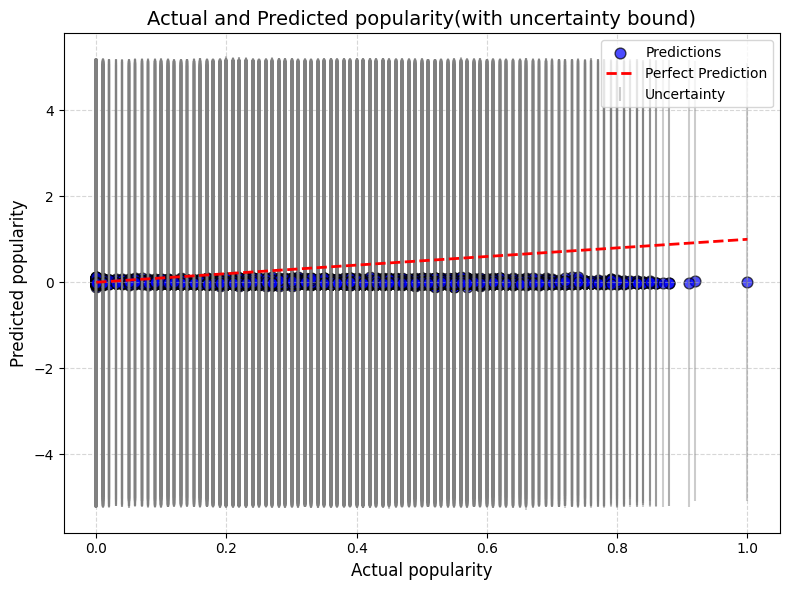

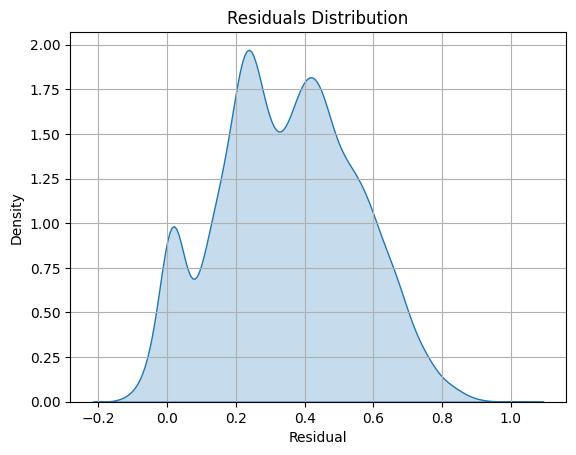

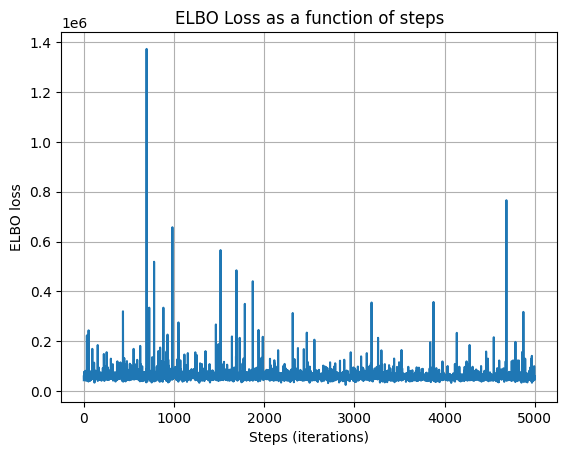

Final ELBO: 58998.26
MSE value: 0.1605
Mean uncertainty: 2.5724


In [ ]:
# Plot of actual and predicted popularity with uncertainty bound
plt.figure(figsize=(8, 6))
plt.scatter(test_data_y, mean_pred_y, alpha=0.7, c='b', edgecolors='k', s=60, label='Predictions')
plt.errorbar(test_data_y, mean_pred_y, yerr=2*dev_pred_y, fmt='none', ecolor='grey', alpha=0.4, linewidth=1.5, label='Uncertainty')
min_val, max_val = test_data_y.min(), test_data_y.max()
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual popularity', fontsize=12)
plt.ylabel('Predicted popularity', fontsize=12)
plt.title('Actual and Predicted popularity(with uncertainty bound)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Next we plot distribution of residual
res = test_data_y - mean_pred_y
sns.kdeplot(res, fill=True)
plt.xlabel('Residual')
plt.title('Residuals Distribution')
plt.grid()
plt.show()

# Here we plot ELBO loss w.r.t. iterations
plt.plot(approx.hist)
plt.xlabel('Steps (iterations)')
plt.ylabel('ELBO loss')
plt.title('ELBO Loss as a function of steps')
plt.grid()
plt.show()

# Diplaying final values
print("Final ELBO:", round(approx.hist[-1], 2))
print("MSE value:", round(mse, 4))
print("Mean uncertainty:", round(np.mean(dev_pred_y), 4))

# Clustering using GMM

In [ ]:
# We select few features for clustering mood bucket
ftr_mood = ['danceability', 'valence']
data_mood = dataset_scaled[ftr_mood]
clstr_num = 9
gmm = GaussianMixture(n_components=clstr_num, random_state=42, n_init=10, max_iter=100)
clusters = gmm.fit_predict(data_mood)
dataset_scaled['gmm_mood_cluster'] = clusters
# Clustering is evaluated using Silhouette score. It finds the distance of each point from each cluster.
sil_score = silhouette_score(data_mood, clusters)
print(f"Silhouette Score: {sil_score:.3f}")
# If actual cluster details are available, we find ARI score which measures similarity between true and predicted clusters.
if 'mood_bucket_encoded' in dataset_scaled.columns:
    ari = adjusted_rand_score(dataset_scaled['mood_bucket_encoded'], clusters)
    print(f"Adjusted Rand Index (vs. mood_bucket_encoded): {ari:.3f}")

Silhouette Score: 0.334
Adjusted Rand Index (vs. mood_bucket_encoded): 0.483


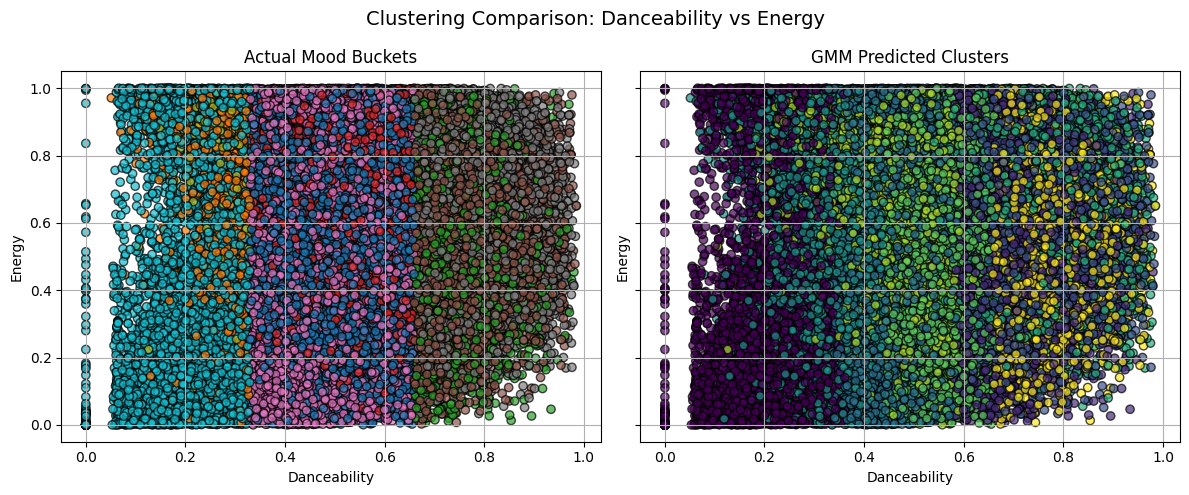

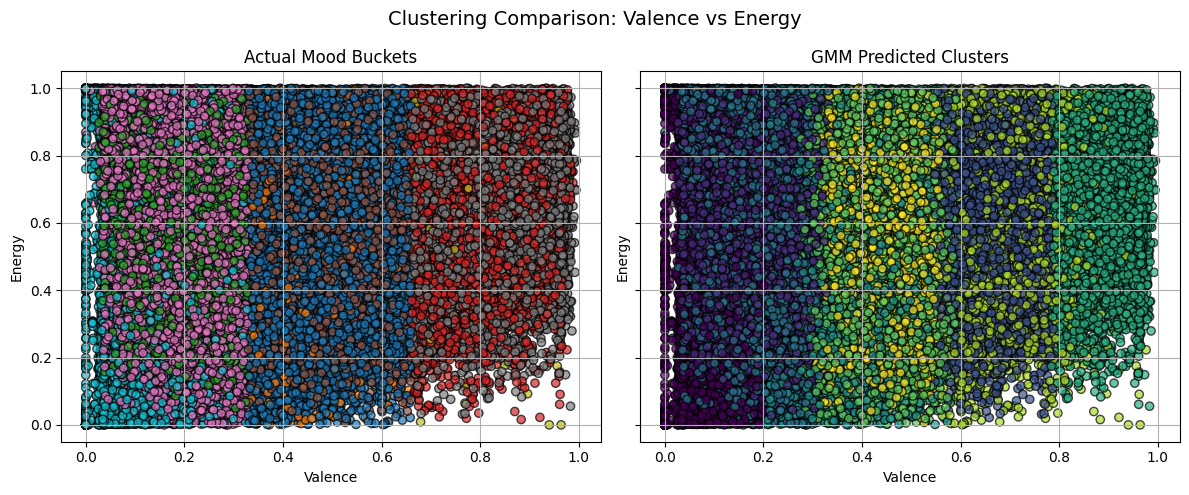

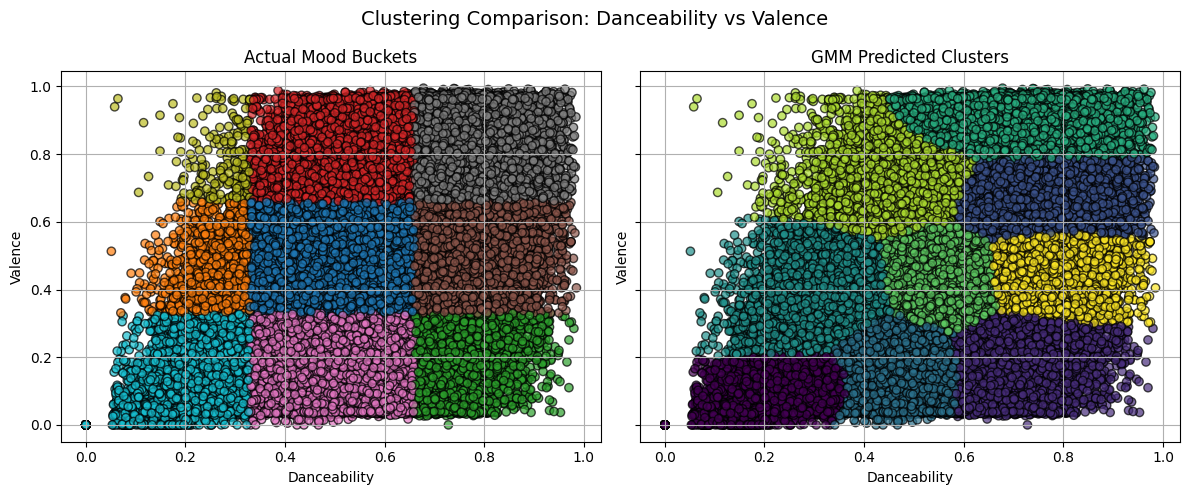

In [ ]:
feature_pairs = [('danceability', 'energy'), ('valence', 'energy'), ('danceability', 'valence')]
for f_x, f_y in feature_pairs:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
    if 'mood_bucket_encoded' in dataset_scaled.columns:
        axes[0].scatter(
            dataset_scaled[f_x], dataset_scaled[f_y],
            c=dataset_scaled['mood_bucket_encoded'], cmap='tab10',
            alpha=0.7, edgecolors='k'
        )
        axes[0].set_title('Actual Mood Buckets')
    else:
        axes[0].text(0.5, 0.5, 'No actual labels available',
                     ha='center', va='center', fontsize=12)
        axes[0].set_title('Actual')

    axes[1].scatter(
        dataset_scaled[f_x], dataset_scaled[f_y],
        c=dataset_scaled['gmm_mood_cluster'], cmap='viridis',
        alpha=0.7, edgecolors='k'
    )
    axes[1].set_title('GMM Predicted Clusters')

    for ax in axes:
        ax.set_xlabel(f_x.capitalize())
        ax.set_ylabel(f_y.capitalize())
        ax.grid(True)
    plt.suptitle(f'Clustering Comparison: {f_x.capitalize()} vs {f_y.capitalize()}', fontsize=14)
    plt.tight_layout()
    plt.show()

# Classification using Bayesian Logistic regression

In [36]:
# Here we'll classify the dataset based on 'track_genre' using logistic regression
from scipy.special import softmax
# Only 10000 data will be taken entirely
# Out of that, we take 70% as train, 30% as test data set
# Data is taken in a stratified manner with respect to track_genre
data_genre = dataset_scaled.sample(n=10000, random_state=42)
# Features to be used for modelling track_genre
ftr_genre = ['popularity', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
X = data_genre[ftr_genre]
y = data_genre['track_genre']
# Define train and test data
x_train_genre, x_test_genre, y_train_genre, y_test_genre = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
y_train_genre_encoded = y_train_genre.astype('category').cat.codes
y_test_genre_encoded = y_test_genre.astype('category').cat.codes

In [38]:
n_classes = len(y_train_genre_encoded.unique())
n_features = x_train_genre.shape[1]
# Implementation of the model
with pm.Model() as model:
    wgts = pm.Normal('weights', mu=0, sigma=1, shape=(n_features, n_classes))
    intercept = pm.Normal('intercept', mu=0, sigma=1, shape=(n_classes,))
    lgt = pm.math.dot(x_train_genre.values, wgts) + intercept
    probs = pm.math.softmax(lgt, axis=-1)
    y_obs = pm.Categorical('y_obs', p=probs, observed=y_train_genre_encoded.values)
    approx = pm.fit(50000, method='advi')
    elbo_vals = approx.hist
    posterior_samples = approx.sample(draws=500)

# Next we extract weights and intercept from posterior using arviz inference data
sample_wgt = posterior_samples.posterior['weights'].stack(sample=("chain", "draw")).values
sample_intr = posterior_samples.posterior['intercept'].stack(sample=("chain", "draw")).values
weights_mean = sample_wgt.mean(axis=2) # Taking the mean over samples
intercept_mean = sample_intr.mean(axis=1) # Taking the mean over samples
lgt_test = np.dot(x_test_genre, weights_mean) + intercept_mean
probs_test = softmax(lgt_test, axis=1)
y_pred = np.argmax(probs_test, axis=1)

Output()

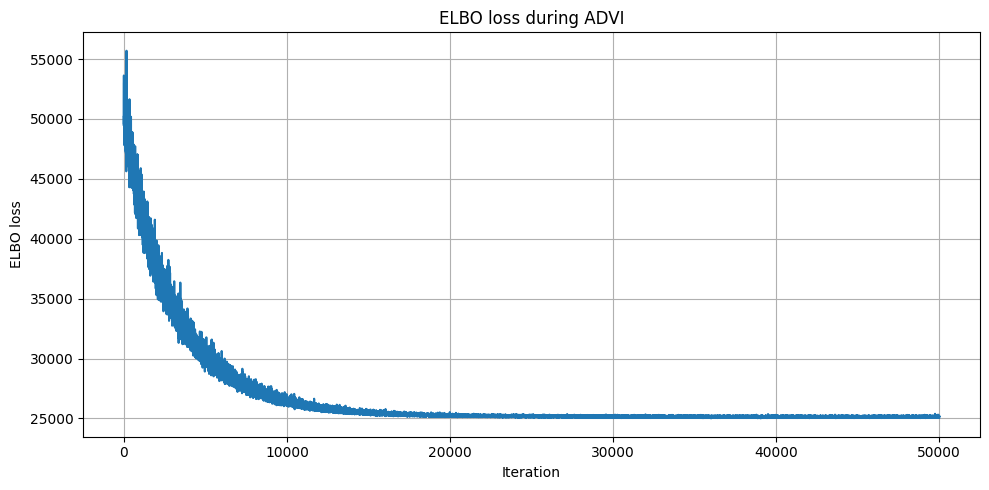

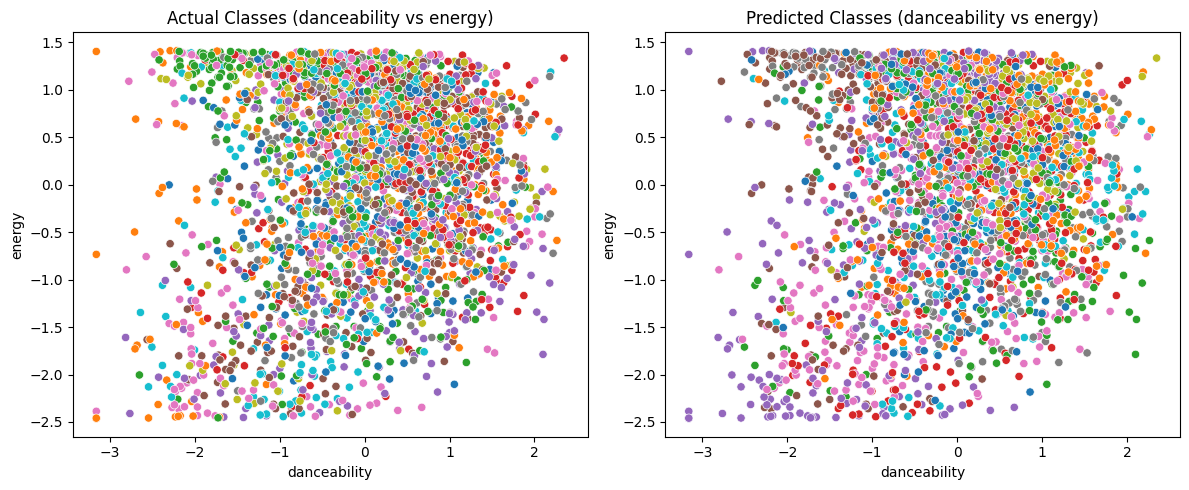

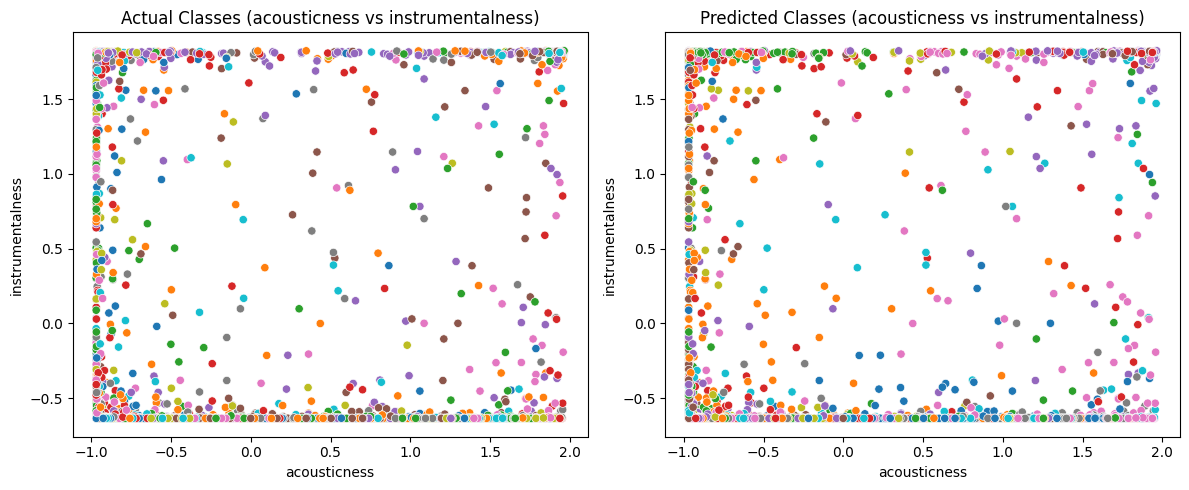

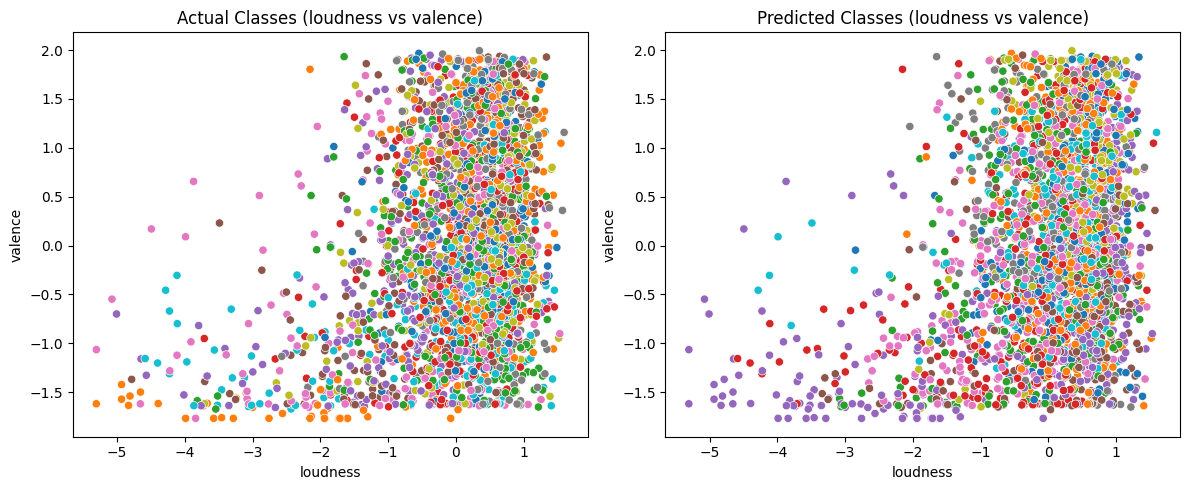

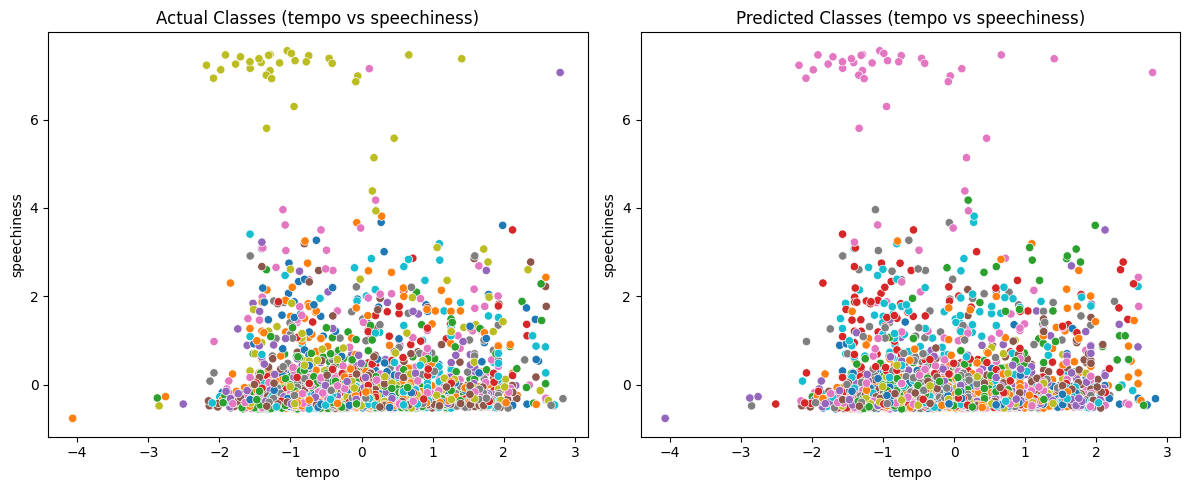

In [40]:
# Plotting the ELBO loss as a function of iterations
plt.figure(figsize=(10, 5))
plt.plot(elbo_vals)
plt.xlabel("Iteration")
plt.ylabel("ELBO loss")
plt.title("ELBO loss during ADVI")
plt.grid(True)
plt.tight_layout()
plt.show()

# Here we select pairs of features to visualize the actual VS predicted classes
feature_pairs = [('danceability', 'energy'), ('acousticness', 'instrumentalness'), ('loudness', 'valence'), ('tempo', 'speechiness')]
x_test_df = x_test_genre.copy()
x_test_df['Actual'] = y_test_genre_encoded
x_test_df['Predicted'] = y_pred
for (f1, f2) in feature_pairs:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=x_test_df, x=f1, y=f2, hue='Actual', palette='tab10', legend=False)
    plt.title(f'Actual Classes ({f1} vs {f2})')
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=x_test_df, x=f1, y=f2, hue='Predicted', palette='tab10', legend=False)
    plt.title(f'Predicted Classes ({f1} vs {f2})')
    plt.tight_layout()
    plt.show()